In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set(font_scale=1.5)
sbn.set_style('white')

%matplotlib inline

# Visualization

This script visualizes the data produced by the previous two scripts. This includes a summary table examining the gRNAs grouped by region as well as determining the number of Broad Spectrum gRNAs. Next, the cleavage results are visualized across the HXB2 genome as well as plotted against the entropy of the region. Finally, a heatmap is created to vizualize why certain gRNAs are likely ineffective against patient samples.

In [2]:
data = pd.read_excel('results/SupTable1.xlsx')
res = pd.read_excel('results/FrequencyTables/26607397_LTR-2.xlsx')
data.head()

,Citation,Name,Start,Stop,gRNA,Percent cleaved,Entropy (bits),Number of Sequences Evaluated,Region,MIT Score
0,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,68.274303,2.615312,1327,LTR,67.0
1,23974631,T6,343,362,GCTACAAGGGACTTTCCGCT.NGG,84.306293,2.959877,1319,LTR,NaN
2,25049410,LTR-A,98,127,AGGGCCAGGGATCAGATATCCACTGACCTT.NGG,55.044700,5.249049,783,LTR,NaN
3,25049410,LTR-B,312,341,CCN.GAGTACTTCAAGAACTGCTGACATCGAGCT,21.412639,4.605056,1345,LTR,NaN
4,25049410,LTR-C,78,97,GATTGGCAGAACTACACACC.NGG,70.325203,2.660178,492,LTR,81.0


In [3]:
# Here we're defining Broad Spectrum as those which cleave 50% of sequences

data['EF50'] = data['Percent cleaved'] >= 50
data['EF90'] = data['Percent cleaved'] >= 90
rdict = {'Gag': 'Gag/Pol', 'Pol': 'Gag/Pol'}
sum_table = data.replace(rdict).groupby('Region').agg({'gRNA': 'count', 
                                                       'EF50':'sum',
                                                       'EF90':'sum'}).astype(int)
sum_table

,EF90,gRNA,EF50
Region,,,
Env,2,14,5
Gag/Pol,0,53,30
LTR,2,135,82
Nef,0,1,1
Rev/Env,0,3,3
Tat/Rev,0,2,2
Vif,0,2,0
Vpr,0,1,0


In [4]:
sum_table[['gRNA', 'EF50', 'EF90']].to_excel('results/Table1.xlsx')

In [5]:
-(res.clip_lower(1.0/10000)*np.log2(res.clip_lower(1.0/10000)))

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
A,0.044790,0.028965,0.032233,0.018145,0.096478,0.067176,0.077410,0.040382,0.114067,0.074043,...,-0.000000,0.001329,0.005841,0.032233,0.154195,0.235023,0.266068,0.017451,0.056352,0.018145
C,0.077410,0.018145,0.122406,0.044790,0.032233,0.001329,0.034685,0.044790,0.096478,0.032233,...,0.001329,0.008752,0.032233,0.008752,0.331047,0.090536,0.109490,0.001329,0.018145,0.032233
G,0.028965,0.032233,0.077410,0.044790,0.031828,0.017451,0.056352,0.044790,0.062922,0.032233,...,0.001329,0.018145,0.001329,0.018145,0.067176,0.018145,0.001329,0.067176,0.020338,0.017451
T,0.018145,0.087153,0.054515,0.020338,0.018145,0.018145,0.032233,0.096478,0.056352,0.193947,...,0.001329,0.032233,0.001329,0.001329,0.032233,0.032233,0.067176,0.018145,0.032233,0.044790


In [6]:
import FigureTools
reload(FigureTools)

<module 'FigureTools' from 'FigureTools.pyc'>

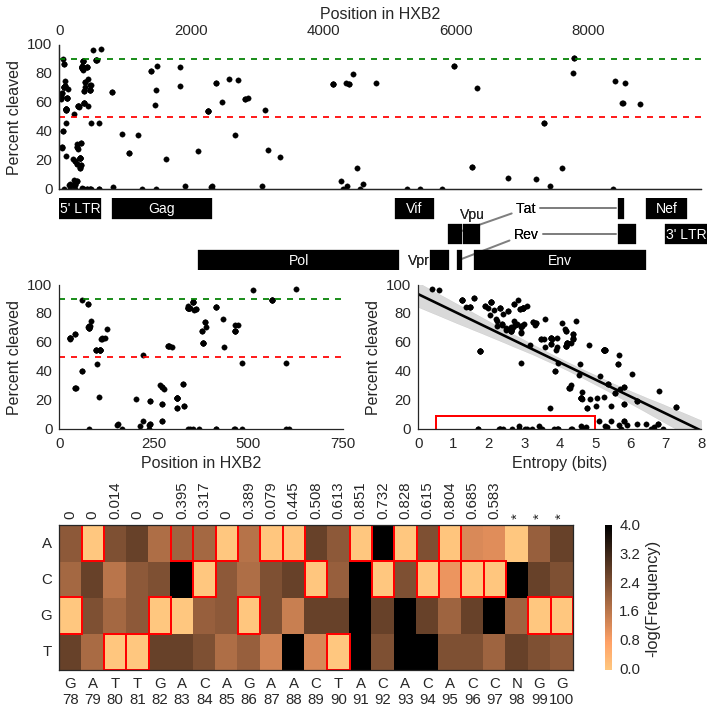

In [7]:
hxb2_ax = plt.subplot2grid((3,2), (0,0), colspan=2)
FigureTools.generate_genome_plot(hxb2_ax, data, top_axis=True)
hxb2_ax.hlines(50, 0, 9717, linestyle = '--', color = 'r')
hxb2_ax.hlines(90, 0, 9717, linestyle = '--', color = 'g')

ltr_ax = plt.subplot2grid((3,2), (1,0))
ltr_ax.hlines(50, 0, 750, linestyle = '--', color = 'r')
ltr_ax.hlines(90, 0, 750, linestyle = '--', color = 'g')
FigureTools.generate_genome_plot(ltr_ax, data, xlims=(0, 700))
ltr_ax.set_xticks([0, 250, 500, 750])


ent_ax = plt.subplot2grid((3,2), (1,1))
FigureTools.generate_entropy_plot(ent_ax, data)

heat_ax = plt.subplot2grid((3,2), (2,0), colspan=2)
FigureTools.generate_heatmap(heat_ax, res.clip_lower(1.0/10000), 'GATTGACAGAACTACACACCNGG', 78,
                             vmin=0, vmax=4)


fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()

ax = fig.add_axes([0.0875, 0.62, .90, 0.1])
FigureTools.generate_hiv_orfs(ax)

fig.savefig('results/Fig1ABCD.png', dpi=300)

In [8]:
from itertools import islice
import os

def freq_path(citation, name, base_dir = 'results/FrequencyTables/'):
    
    fname = '%i_%s.xlsx' % (citation, name.strip())
    return os.path.join(base_dir, fname.replace(' ', '-'))

# Produce the frequency heatmap for all gRNAs

for _, row in data.iterrows():
    
    path = freq_path(row['Citation'], row['Name'])
    freqs = pd.read_excel(path)

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    for_strand = row['gRNA'].endswith('.NGG')
    
    # Deal with orientation and length issues
    if for_strand:
        target = row['gRNA'].replace('.', '')[-23:]
    else:
        target = row['gRNA'].replace('.', '')[:23]
        
    FigureTools.generate_heatmap(ax, freqs.clip_lower(1.0/10000), 
                                 target, row['Start'], for_strand=for_strand)
    
    ax.set_ylabel(row['Name'] + ' %i' % row['Percent cleaved'] + '% cleaved')
    
    fig.tight_layout()
    fig.savefig(path.replace('.xlsx', '.png'))
    plt.close()
    